In [35]:
# Do any installations of libraries here
!pip install pyproj

In [ ]:
# Author: Rthvik Raviprakash
# Email: rravipra@uw.edu

# This notebook provides the code for calculating the smoke impact estimate:

A lot of the code has been reused from the jupyter notebook code that illustrate how to perform some basic geodetic computations related to the Wildfire course project. The notebook is structure as a set of examples that illustrate something about the structure of the data or illustrate a way to compute specific values. This notebook is not a tutorial on performing geodetic computations, but illustrates a number of key concepts. This notebook should provide enough information to complete the Wildfire assignment.

The complete [Wildfire dataset](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81) can be retrieved from a US government repository. I have noticed that the repository is sometimes "down" and does not respond. It probably makes sense to get the dataset as soon as possible.

This notebook has dependencies on [Pyproj](https://pyproj4.github.io/pyproj/stable/index.html), the [geojson](https://pypi.org/project/geojson/) module and on the wildfire user module. Pyproj and geojson can be installed via pip. The wildfire user module should be downloaded from the course website, unzipped, and moved into the folder pointed to by your PYTHONPATH system variable.

License
Most of the code used in this was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. The code is provided under the [Creative Commons](https://creativecommons.org/) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.0 - August 13, 2023

In [1]:
#
#    IMPORTS
#
#    Import some standard python modules
import os, json, time
#
#    The module pyproj is a standard module that can be installed using pip or your other favorite
#    installation tool. This module provides tools to convert between different geodesic coordinate systems
#    and for calculating distances between points (coordinates) in a specific geodesic system.
#
from pyproj import Transformer, Geod
#
#    The 'wildfire' module is a user module. This module is available from the course website. The module
#    includes one object, a Reader, that can be used to read the GeoJSON files associated with the
#    wildefire dataset. The module also contains a sample datafile that is GeoJSON compliant and that
#    contains a small number of California wildfires extracted from the main wildfire dataset.
#
from wildfire.Reader import Reader as WFReader
#
#    There is a GeoJSON reader that you might try if you wanted to read the data. It has its own quirks.
#    There will be an example below that reads the sample file "Wildfire_short_sample.json"
#
import geojson
#

In [2]:
#
#    CONSTANTS
#
#
#    The 'Wildfire_short_sample.json' is an extraction from the full 'USGS_Wildland_Fire_Combined_Dataset.json'
#    dataset extracting some of the major wildfires in California. These were extracted by name, with possible names
#    coming from https://en.wikipedia.org/wiki/List_of_California_wildfires
#
#    The sample file includes data for 13 fires, mostly oriented around the uniqueness of the name. Naming conventions
#    for wildfires is really adhoc, which makes finding any named fire in the dataset a disambiguation mess. The point
#    of the sample is to provide something small to test with before committing to processing the much larger full dataset.
#
EXTRACT_FILENAME = "USGS_Wildland_Fire_Combined_Dataset.json"

# print out where we think we're going to find the sample data
SAMPLE_DATA_FILENAME = EXTRACT_FILENAME
print(f"{SAMPLE_DATA_FILENAME=}")

#
#    A dictionary of the city location that we are interested in which is Helena, Monatana in my case:
#

# The latlon value can be extracted by finding your city using this link: https://epsg.io/4326

CITY_LOCATIONS = {
    'helena' :     {'city'   : 'Helena',
                    'latlon' : [46.592648, -112.036903] }
}


SAMPLE_DATA_FILENAME='USGS_Wildland_Fire_Combined_Dataset.json'


(46.592648, -112.036903)

The WFReader as you can see has been imported above which is a created library for which the code can be found in the file wildfire.zip in the same Part 1 folder in this github repository.

In the following cells there are small code snippets that do the following:

1. Create a wildfire Reader() object and use it to open the sample data file. Once, opened, we have access to the header information so we print that to show the structure of that data.
2. Use the Reader() object and the next() method to read a set of wildfire features. The small sample file should have 13 of them.
3. Print one example feature showing the dictionary data structure of a feature.
4. Access the geometry of one specific feature to get the 'ring' boundary of that specific fire - which is a list of geodetic coordinates.

Note that some of the output cells are quite long. Once you understand what they are illustrating you might want to collapse them or comment out the print statements that generate the output.

Another note regarding terminology. In the GeoJSON standard, something that is to be represented geographically is generically called a 'feature'. In the case of the wildfire dataset every 'feature' is a wildfire. These terms are used somewhat interchangably below.

In [3]:
# 1.
#    This bit of code opens a new wildfire reader, gets the header information and prints it to the screen
#
print(f"Attempting to open '{SAMPLE_DATA_FILENAME}' with wildfire.Reader() object")
wfreader = WFReader(SAMPLE_DATA_FILENAME)
print()
#
#    Now print the header - it contains some useful information
#
header_dict = wfreader.header()
header_keys = list(header_dict.keys())
print("The header has the following keys:")
print()
print("Header Dictionary")
print(json.dumps(header_dict,indent=4))

Attempting to open 'USGS_Wildland_Fire_Combined_Dataset.json' with wildfire.Reader() object

The header has the following keys:

Header Dictionary
{
    "displayFieldName": "",
    "fieldAliases": {
        "OBJECTID": "OBJECTID",
        "USGS_Assigned_ID": "USGS Assigned ID",
        "Assigned_Fire_Type": "Assigned Fire Type",
        "Fire_Year": "Fire Year",
        "Fire_Polygon_Tier": "Fire Polygon Tier",
        "Fire_Attribute_Tiers": "Fire Attribute Tiers",
        "GIS_Acres": "GIS_Acres",
        "GIS_Hectares": "GIS_Hectares",
        "Source_Datasets": "Source Datasets",
        "Listed_Fire_Types": "Listed Fire Types",
        "Listed_Fire_Names": "Listed Fire Names",
        "Listed_Fire_Codes": "Listed Fire Codes",
        "Listed_Fire_IDs": "Listed Fire IDs",
        "Listed_Fire_IRWIN_IDs": "Listed Fire IRWIN IDs",
        "Listed_Fire_Dates": "Listed Fire Dates",
        "Listed_Fire_Causes": "Listed Fire Causes",
        "Listed_Fire_Cause_Class": "Listed Fire Cause

The code below loads the data into a list where each item of the list is a dictionary for which an example is given in the next code cell after the one below:

In [4]:
#
#    This sample code will load the whole sample file, or a small amount of the complete dataset.
#

#2. 

MAX_FEATURE_LOAD = 100
feature_list = list()
feature_count = 0
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result
wfreader.rewind()
# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature_count += 1
    # if we're loading a lot of features, print progress
    if (feature_count % 10000) == 0:
        print(f"Loaded {feature_count} features")
    # loaded the max we're allowed then break
    #if feature_count >= MAX_FEATURE_LOAD:
    #   break
    feature = wfreader.next()
#
#    Print the number of items (features) we think we loaded
print(f"Loaded a total of {feature_count} features")
#
#    Just a validation check - did all the items we loaded get into the list?
print(f"Variable 'feature_list' contains {len(feature_list)} features")

Loaded 10000 features
Loaded 20000 features
Loaded 30000 features
Loaded 40000 features
Loaded 50000 features
Loaded 60000 features
Loaded 70000 features
Loaded 80000 features
Loaded 90000 features
Loaded 100000 features
Loaded 110000 features
Loaded 120000 features
Loaded 130000 features
Loaded a total of 135061 features
Variable 'feature_list' contains 135061 features


In [5]:
# 3.
#    The 'feature_list' variable was created when we read the sample file in a code cell above
#    Now, we're just going to look at one single feature - see what is in there
#
SLOT = 0
wf_feature = feature_list[SLOT]

# Print everyting in this dictionary (i.e., wf_feature) - it's long
print(f"The wildfire feature from slot '{SLOT}' of the loaded 'feature_list'")
print(json.dumps(wf_feature, indent=4))

The wildfire feature from slot '0' of the loaded 'feature_list'
{
    "attributes": {
        "OBJECTID": 1,
        "USGS_Assigned_ID": 1,
        "Assigned_Fire_Type": "Wildfire",
        "Fire_Year": 1860,
        "Fire_Polygon_Tier": 1,
        "Fire_Attribute_Tiers": "1 (1)",
        "GIS_Acres": 3940.20708940724,
        "GIS_Hectares": 1594.5452365353703,
        "Source_Datasets": "Comb_National_NIFC_Interagency_Fire_Perimeter_History (1)",
        "Listed_Fire_Types": "Wildfire (1)",
        "Listed_Fire_Names": "Big Quilcene River (1)",
        "Listed_Fire_Codes": "No code provided (1)",
        "Listed_Fire_IDs": "",
        "Listed_Fire_IRWIN_IDs": "",
        "Listed_Fire_Dates": "Listed Other Fire Date(s): 2006-11-02 - NIFC DATE_CUR field (1)",
        "Listed_Fire_Causes": "",
        "Listed_Fire_Cause_Class": "Undetermined (1)",
        "Listed_Rx_Reported_Acres": null,
        "Listed_Map_Digitize_Methods": "Other (1)",
        "Listed_Notes": "",
        "Processing

In [14]:
# this code is just to check the counts of the different type of fires present in the data, this is for me to see the
# different types of fires and give weights for them accordingly which you will see later in this notebook:
arr = {}

for wf_feature in feature_list:
    if wf_feature['attributes']['Assigned_Fire_Type'] not in arr:
        arr[wf_feature['attributes']['Assigned_Fire_Type']] = 1
    else:
        arr[wf_feature['attributes']['Assigned_Fire_Type']] += 1
arr

{'Wildfire': 86219,
 'Unknown - Likely Wildfire': 564,
 'Prescribed Fire': 33321,
 'Likely Wildfire': 11666,
 'Unknown - Likely Prescribed Fire': 3291}

In [6]:
#4. Every feature has a 'geometry' which specifies geo coordinates that make up each geographic thing
#    In the case of the wildfire data, most wildfires are bounded shapes, circles, squares, etc. This is
#    represented by shapes called 'rings' in GeoJSON.
#
# Get the geometry for the feature we pulled from the feature_list
wf_geometry = wf_feature['geometry']
# The largest shape (ring) is supposed to be item zero in the list of 'rings'
wf_bigest_ring = wf_geometry['rings'][0]

print(f"The largest ring of wf_feature['features'][{SLOT}]['rings'] consists of {len(wf_bigest_ring)} points.")

The largest ring of wf_feature['features'][0]['rings'] consists of 768 points.


One of the constraints in doing geodetic computations is that most of the time we need to have our points (the coordinates for places) in the same geographic coordinate system. There are tons and tons of coordinate systems. You can find descriptions of many of them at [EPSG.io](https://epsg.io).

Looking at the wildfire header information, you can find this in the output of Example 1, we can see fields named "geometryType" and "spatialReference". This looks like:

        "geometryType": "esriGeometryPolygon",
        "spatialReference": {
            "wkid": 102008,
            "latestWkid": 102008
        },

This indicates that the geometry of our wildfire data are generic polygons and that they are expressed in a coordinate system with the well-known ID (WKID) 102008. This coordinate system is also known as [ESRI:102008](https://epsg.io/102008)

Below you in the cell next to the one below you will see the code: geocalc = Geod(ellps='WGS84')         # Use WGS84 ellipsoid representation of the earth

The string, 'WGS84', is a representation of the earth, that also relies on a well known coordinate system that is sometimes called 'decimal degrees' (DD). That decimal degrees system has an official name (or WKID) of [EPSG:4326](https://epsg.io/4326).

Next we're going to do is take the geometry of a fire feature, extract the largest ring (i.e., the largest boundary of the fire) and convert all of the points in that ring from the ESRI:102008 coordinate system to EPSG:4326 coordinates.

In [8]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [9]:
#
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#

def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point

#
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average

As I metioned previously I have added weights based on the type of fire and how much impact it can have below in a dictonary and then further used them as a multiplying factor for my smoke impact estimates.

In [11]:
weights = {
    'Wildfire': 1.0,
    'Unknown - Likely Wildfire': 0.85,
    'Prescribed Fire': 0.7,
    'Likely Wildfire': 0.9,
    'Unknown - Likely Prescribed Fire': 0.55
}

The code below is the most important part of the estimate and the visualizations:

The smoke estimate for a feature (for a fire) is calculated by the formula (weight * fire_size)/(distance ** 2) where the weight is the weight given based on the type of fire the way that I have defined above, further the fire_size is the acres value for that feature and the distance is the distance calculated using the shortest_distance_from_place_to_fire_perimeter() function defined previously. I append each of these values to a list (values of the dictionary) based on the years (keys of the dictionary).

Further, I also calculate the number of fires based on the distances and put them in 50 mile intervals (i.e distance from Helena, Montana) for the visualization later.

I also do the same for calculating the total number of acres per year:

In [12]:
# Your pseudo-formula could look like this:
# smoke_impact = fire_size / distance_factor
# Where distance_factor is some function of the distance, for example, 1/distance or a logarithmic scale to diminish the effect of distance.
import time
place = CITY_LOCATIONS["helena"]

def calculate_smoke_impact(fire_size, distance, fire_type, weights):
    if distance > 0:  # Prevent division by zero
        wgt = 1.0
        if fire_type in weights:
            wgt = weights[fire_type]
        else:
            wgt = 1.0
            
        return wgt * (fire_size / (distance ** 2))  # Example of diminishing impact with distance squared
    else:
        return 0

# Define a dictionary to hold the annual smoke impact estimates
annual_smoke_impact = {}
start_time = time.time()
feature_count = 0

# Step 1: Data Preparation
fire_counts = {(i, i+50): 0 for i in range(0, 1250, 50)}
acres_burned_annual = {}

for wf_feature in feature_list:
    wf_year = wf_feature['attributes']['Fire_Year']
    feature_count += 1
    if (feature_count % 10000) == 0:
        # Calculate elapsed time
        elapsed_time = time.time() - start_time
        elapsed_time_minutes = elapsed_time / 60
        print(f"Loaded {feature_count} features, time elapsed: {elapsed_time_minutes:.2f} minutes")
        
    # Ensure the fire is within the last 60 years and the fire season
    
    if 1963 <= wf_year <= 2023:
        if 'rings' in wf_feature['geometry']:
            wf_size = wf_feature['attributes']['GIS_Acres']
            ring_data = wf_feature['geometry']['rings'][0]
            fire_type = wf_feature['attributes']['Assigned_Fire_Type']

            # Calculate the shortest distance from the city to the fire perimeter
            distance = shortest_distance_from_place_to_fire_perimeter(place['latlon'], ring_data)[0]

            # Only consider fires within 1250 miles
            if distance <= 1250:
                # Calculate smoke impact estimate
                smoke_impact = calculate_smoke_impact(wf_size, distance, fire_type, weights)

                # Add the smoke impact to the annual total for that year
                if wf_year not in annual_smoke_impact:
                    annual_smoke_impact[wf_year] = [smoke_impact]
                else:
                    annual_smoke_impact[wf_year].append(smoke_impact)
                    
                 # Counting fires for the histogram
                distance_range = (50 * (int(distance) // 50), 50 * (int(distance) // 50) + 50)
                if distance_range in fire_counts:
                    fire_counts[distance_range] += 1

                # Summing acres burned for the time series
                if wf_year not in acres_burned_annual:
                    acres_burned_annual[wf_year] = wf_size
                else:
                    acres_burned_annual[wf_year] += wf_size

Loaded 10000 features, time elapsed: 0.00 minutes
Loaded 20000 features, time elapsed: 9.11 minutes
Loaded 30000 features, time elapsed: 33.82 minutes
Loaded 40000 features, time elapsed: 53.00 minutes
Loaded 50000 features, time elapsed: 74.68 minutes
Loaded 60000 features, time elapsed: 97.82 minutes
Loaded 70000 features, time elapsed: 121.88 minutes
Loaded 80000 features, time elapsed: 144.27 minutes
Loaded 90000 features, time elapsed: 160.83 minutes
Loaded 100000 features, time elapsed: 177.75 minutes
Loaded 110000 features, time elapsed: 237.53 minutes
Loaded 120000 features, time elapsed: 256.22 minutes
Loaded 130000 features, time elapsed: 274.05 minutes


Save the files in a json format:

In [ ]:
import json

with open('annual_smoke_impact_final.json', 'w') as file:
    # Use json.dump to write the dictionary to the file
    json.dump(annual_smoke_impact, file, indent=4)

# Convert tuple keys to strings
data_str_keys = {str(key): value for key, value in fire_counts.items()}

# Save to a JSON file
with open('fire_counts_final.json', 'w') as json_file:
    json.dump(data_str_keys, json_file, indent=4)

with open('acres_burned_annual.json', 'w') as json_file:
    json.dump(acres_burned_annual, json_file, indent=4)

In [93]:
# to show the average values calcuated for a year which would be out smoke impact:
res = {}
for k, v in annual_smoke_impact.items():
    res[k] = (sum(annual_smoke_impact[k])/len(annual_smoke_impact[k]), len(annual_smoke_impact[k]))
res

{1963: (0.007800331027438047, 377),
 1964: (0.004829712778458158, 380),
 1965: (0.00518706758883699, 330),
 1966: (0.01654370292339489, 421),
 1967: (0.01399699405198448, 447),
 1968: (0.008185538258850086, 442),
 1969: (0.007188477246561168, 343),
 1970: (0.008762806278623051, 601),
 1971: (0.01457307234820586, 441),
 1972: (0.004794367000175361, 472),
 1973: (0.0155252078270121, 501),
 1974: (0.003773690613392735, 626),
 1975: (0.003628167417161194, 525),
 1976: (0.005138750145377783, 591),
 1977: (0.0031066030479181043, 531),
 1978: (0.004696959996999108, 528),
 1979: (0.015443774438389995, 812),
 1980: (0.003748845718822959, 945),
 1981: (0.016673963352331313, 1007),
 1982: (0.00405854117901546, 640),
 1983: (0.008303405876329283, 814),
 1984: (0.18603387340274177, 1077),
 1985: (0.018102719384519034, 1379),
 1986: (0.0113244259888867, 1290),
 1987: (0.007105232416977346, 1659),
 1988: (0.4367779774120426, 1610),
 1989: (0.008654331206643667, 1386),
 1990: (0.02575016693716941, 109

Make the plots below:

1. A histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.
2. A time series graph of total acres burned per year for the fires occurring in the specified distance from your city.

# PLOT 1:

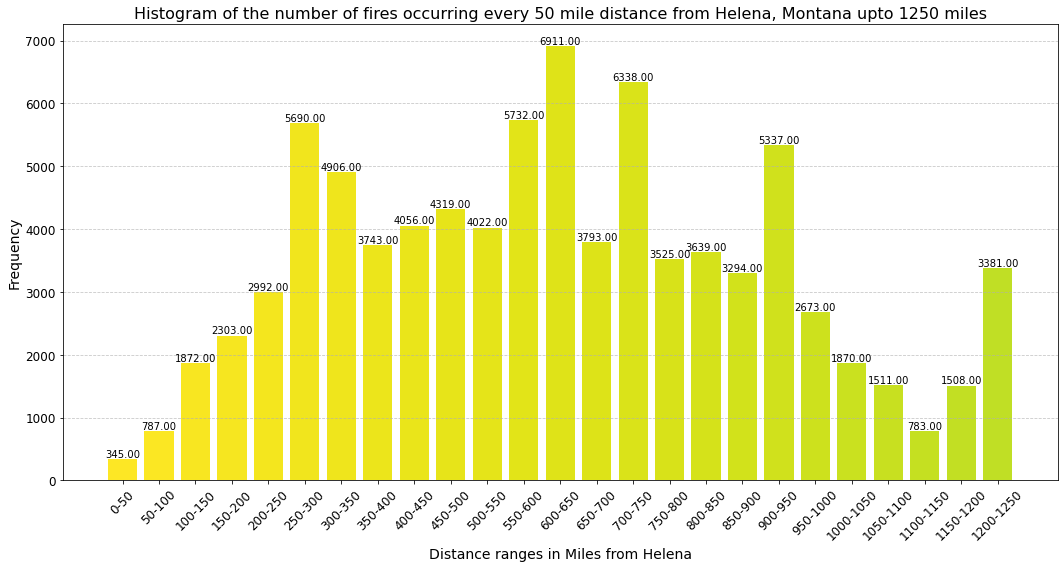

In [39]:
# Visualization: PLOT 1:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Prepare data for histogram
ranges = [f"{key[0]}-{key[1]}" for key in fire_counts.keys()]
frequencies = [value for value in fire_counts.values()]

# 'ranges' and 'frequencies' are defined for your histogram
plt.figure(figsize=(15, 8))
colors = plt.cm.viridis_r(range(len(ranges)))  # Using a colormap for variety
plt.bar(ranges, frequencies, color=colors)

plt.xlabel('Distance ranges in Miles from Helena', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histogram of the number of fires occurring every 50 mile distance from Helena, Montana upto 1250 miles', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Adding value labels
for i in range(len(ranges)):
    plt.text(i, frequencies[i], f'{frequencies[i]:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

# PLOT 2:

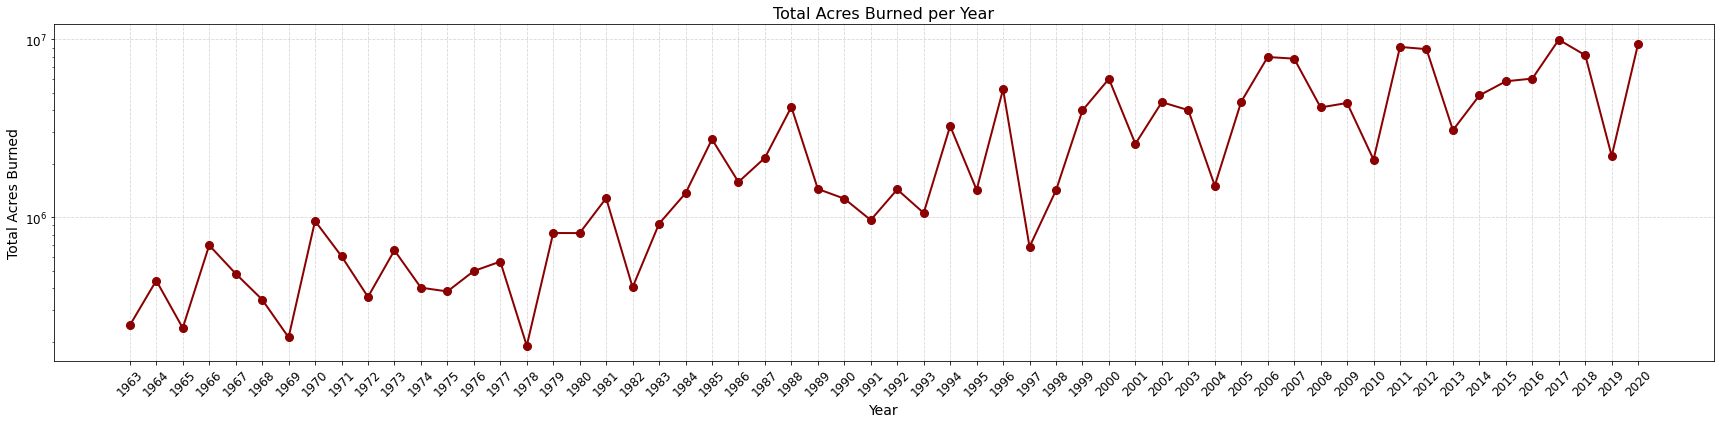

In [40]:
#'acres_burned_annual' is defined for the time series
years = sorted(acres_burned_annual.keys())
total_acres_burned = [acres_burned_annual[year] for year in years]

plt.figure(figsize=(24, 6))
plt.plot(years, total_acres_burned, marker='o', linestyle='-', color='darkred', linewidth=2, markersize=8)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Acres Burned', fontsize=14)
plt.title('Total Acres Burned per Year', fontsize=16)

# Explicitly setting x-ticks to display each year
plt.xticks(years, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Use ScalarFormatter to display full numbers
formatter = ticker.ScalarFormatter(useOffset=False)
plt.gca().yaxis.set_major_formatter(formatter)

plt.yscale('log')
plt.tight_layout()
plt.show()